# Module 10 Challenge: Climate Starter

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
print(most_recent_date)

2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_dt = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
days = 30 * 12
one_year_from_recent_dt = most_recent_dt - dt.timedelta(days=days)

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement).\
    filter(measurement.date >= one_year_from_recent_dt, measurement.date <= most_recent_date)\
    .with_entities(measurement.date, measurement.prcp)\
    .statement

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql(query, session.bind)
df.rename(columns={
    'date': 'Date',
    'prcp': 'Precipitation'
}, inplace=True)

# Sort the dataframe by date
df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df

,Date,Precipitation
0,2016-08-29,0.00
991,2016-08-29,NaN
1501,2016-08-29,0.35
692,2016-08-29,0.04
355,2016-08-29,0.17
...,...,...
1499,2017-08-22,0.00
1500,2017-08-23,0.08
354,2017-08-23,0.00
990,2017-08-23,0.00


<Axes: xlabel='Date'>

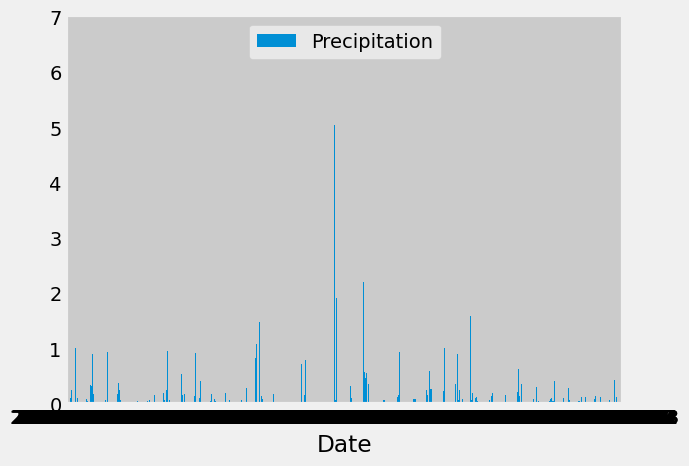

In [11]:
df.plot.bar(x='Date', y='Precipitation', rot=0)

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
mean = df['Precipitation'].mean()
median = df['Precipitation'].median()
var = df['Precipitation'].var()
std = df['Precipitation'].std()
sem = df['Precipitation'].sem()

# display the summary statistics for the precipitation data
print('Summary Statistics of Precipitation Data')
print()
print(f'\tMean: {round(mean, 5)}')
print(f'\tMedian: {median}')
print(f'\tVariance: {round(var, 5)}')
print(f'\tStandard Deviation: {round(std, 5)}')
print(f'\tStandard Error of Mean: {round(sem, 5)}')

Summary Statistics of Precipitation Data

	Mean: 0.17238
	Median: 0.02
	Variance: 0.20544
	Standard Deviation: 0.45325
	Standard Error of Mean: 0.01017


## Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
total_stations

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.\
    query(measurement.station, func.count(measurement.station).label('station_count'))\
    .group_by(measurement.station)\
    .order_by(sqlalchemy.desc('station_count'))\
    .all()

# determine which station has the highest count
max_count = 0
max_station = ''

print('Station     - Count')
print('-------------------')
for station, count in station_counts:
    print(f'{station} - {count}')
    if count > max_count:
        max_station = station
        max_count = count

print()
print(f'Station {max_station} has the greatest number of observations with a count of {max_count}.')

Station     - Count
-------------------
USC00519281 - 2772
USC00519397 - 2724
USC00513117 - 2709
USC00519523 - 2669
USC00516128 - 2612
USC00514830 - 2202
USC00511918 - 1979
USC00517948 - 1372
USC00518838 - 511

Station USC00519281 has the greatest number of observations with a count of 2772.


In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# query all records from most active station ID
most_active_station_records = session.query(measurement).filter_by(station=max_station).all()

# convert query to a list of temperatures
temps = [record.tobs for record in most_active_station_records]

# calculate lowest, highest, and average temperature
min_temp = min(temps)
max_temp = max(temps)
mean_temp = round(sum(temps) / len(temps), 2)

# display the lowest, highest, and average temperature
print(f'Station {max_station} Temperatures')
print()
print(f'Lowest temperature: {min_temp}')
print(f'Highest temperature: {max_temp}')
print(f'Average (mean) temperature: {mean_temp}')

Station USC00519281 Temperatures

Lowest temperature: 54.0
Highest temperature: 85.0
Average (mean) temperature: 71.66


<Axes: xlabel='date'>

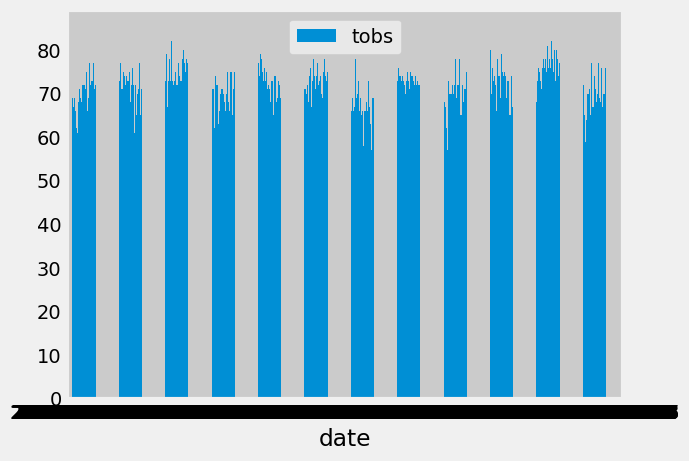

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(measurement).\
    filter(measurement.station == max_station)\
    .with_entities(measurement.date, measurement.tobs)\
    .statement

# Save the query results as a Pandas DataFrame
df = pd.read_sql(query, session.bind)
df.plot.bar(x='date', y='tobs', rot=0)

## Close Session

In [33]:
# Close Session
session.close()